In [156]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

In [215]:
class KalmanFilter(object):
    def __init__(self, F, Q, H, R, u):
        """
        Initialize the dynamical system models.
        Parameters
        ----------
        F : ndarray of shape (n,n)
        The state transition model.
        Q : ndarray of shape (n,n)
        The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
        The observation model.
        R : ndarray of shape (m,m)
        The covariance matric for observation noise.
        u : ndarray of shape (n,)
        The control vector.
        """
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman -
        system.
        Parameters
        ----------
        x0 : ndarray of shape (n,)
        The initial state.
        N : integer
        The number of time steps to evolve.
        Returns
        -------
        states : ndarray of shape (n,N)
        States 0 through N-1, given by each column.
        obs : ndarray of shape (m,N)
        Observations 0 through N-1, given by each column.
        """
        x0 = x0.reshape(1,4)
        states = [x0.T]
        obs = []
        obnoise = np.random.multivariate_normal(np.zeros(2), R).reshape(1,2)
        ob = self.H.dot(x0.T).T + obnoise
        obs.append(ob)
        print x0.shape
        x0 = x0.reshape(1,4)
        
        for n in range(N):
            statenoise = np.random.multivariate_normal(np.zeros(4), Q).reshape(1,4)
            obnoise = np.random.multivariate_normal(np.zeros(2), R).reshape(1,2)
            
            newState = (self.F.dot(x0.T).T + self.u + statenoise)   # 1x4
#             print newState.shape
            states.append(newState.T)
            ob = self.H.dot(newState.T).T + obnoise
            obs.append(ob)      #1x2?
            
            x0 = newState

        return np.array(states), np.array(obs)
    
    
    def estimate(self,x,P,z):
        """
        Compute the state estimates using the Kalman filter.
        If x and P correspond to time step k, then z is a sequence of
        observations starting at time step k+1.
        Parameters
        ----------
        x : ndarray of shape (n,)
        The initial state estimate.
        P : ndarray of shape (n,n)
        The initial error covariance matrix.
        z : ndarray of shape(m,N)
        Sequence of N observations (each column is an observation).
        Returns
        -------
        out : ndarray of shape (n,N)
        Sequence of state estimates (each column is an estimate).
        """
        out = []
        for i in range(z.shape[0]):
            newX = self.F.dot(x) + self.u
            newP = self.F.dot(P).dot(self.F) + self.Q
            yk = z[i,:].T - self.H.dot(newX).T
            sk = self.H.dot(newP).dot(self.H.T) + self.R
            kk = newP.dot(self.H.T).dot(np.linalg.inv(sk))
            xhat = newX + kk.dot(yk.T)
            Pk = (np.eye(P.shape[0]) - kk.dot(self.H)).dot(newP)
            
            out.append(xhat)
            P = Pk
            x = xhat
            
        return np.array(out)
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.
        Parameters
        ----------
        x : ndarray of shape (n,)
        The current state estimate.
        k : integer
        The number of states to predict.
        Returns
        -------
        out : ndarray of shape (n,k)
        The next k predicted states.
        """
        out = []
        for j in range(k):
            newX = self.F.dot(x) + self.u
            out.append(newX)
            x = newX
            
        return np.array(out)
    
    def rewind(self,x,k):
        """
        Predict the k states preceding the current state estimate x.
        Parameters
        ----------
        x : ndarray of shape (n,)
        The current state estimate.
        k : integer
        The number of preceding states to predict.
        Returns
        -------
        out : ndarray of shape (n,k)
        The k preceding predicted states.
        """
        out = []
        for j in range(k):
            oldX = np.linalg.inv(self.F).dot(x - self.u)
            out.append(oldX)
            x = oldX
            
        return np.array(out)


In [216]:
Q = .1 * np.eye(4)
R = 5000. * np.eye(2)
F = np.eye(4)
F[0,2] = .1
F[1,3] = .1
u = np.array([0,0,0,-.98])
H = np.array([[1,0,0,0],[0,1,0,0]])

kf = KalmanFilter(F, Q, H, R, u)

x0 = np.array([0,0,300,600])
N = 1250

s, o = kf.evolve(x0, N)
o = o[:,0,:]
s = s[:,:,0]

(1L, 4L)


In [217]:
x, y = o[200,:]
vx, vy = np.mean(np.diff(s[200:209,:2], axis=0), axis=0) * 10
x200 = np.array([x,y,vx,vy])
p200 = 10**6 * Q
est = kf.estimate(x200, p200, o[200:800,:])

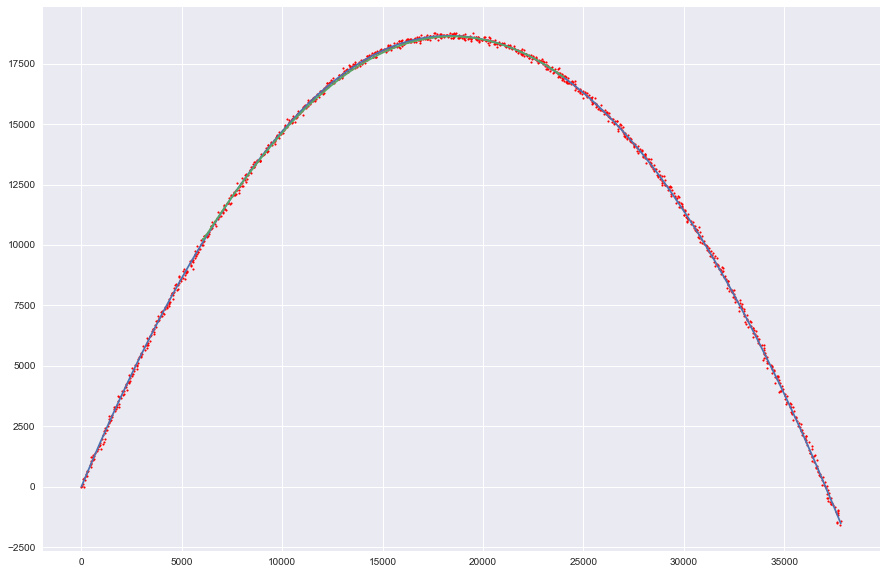

In [218]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot([x[0] for x in s], [x[1] for x in s])
ax.scatter([x[0] for x in o], [x[1] for x in o], s=3, color='Red')
# ax.plot(est[:,0], est[:,1])
plt.plot(est[:,0], est[:,1])

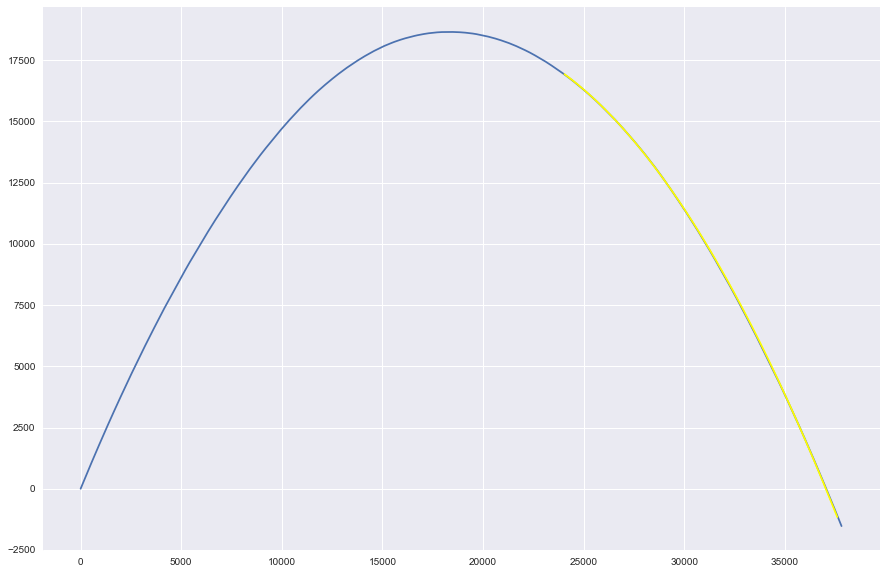

In [219]:
x = est[-1]
pred = kf.predict(x, 450)
fig1, ax1 = plt.subplots(figsize=(15,10))
ax1.plot([x[0] for x in s], [x[1] for x in s])
ax1.plot(pred[:,0], pred[:,1], color='Yellow')

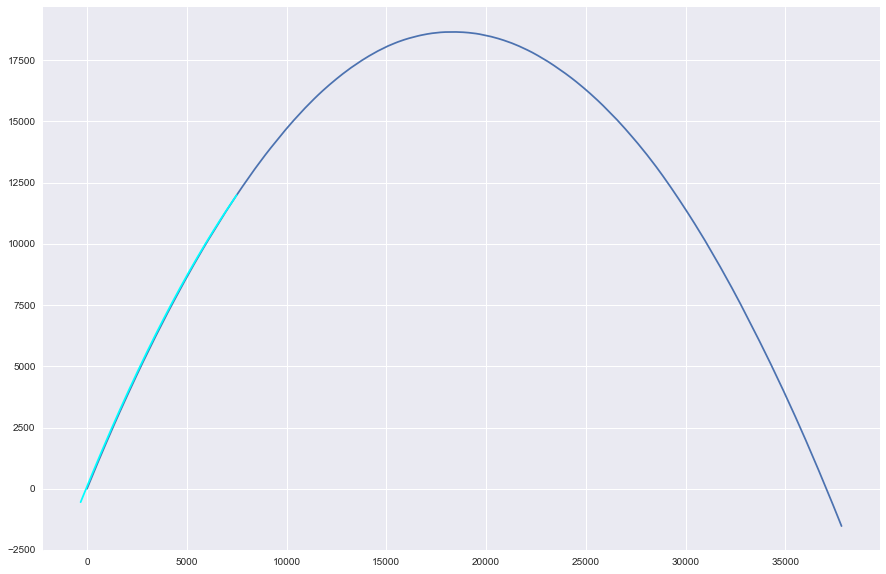

In [220]:
x = est[50]
past = kf.rewind(x, 260)
fig2, ax2 = plt.subplots(figsize=(15,10))
ax2.plot([x[0] for x in s], [x[1] for x in s])
ax2.plot(past[:,0], past[:,1], color='Cyan')

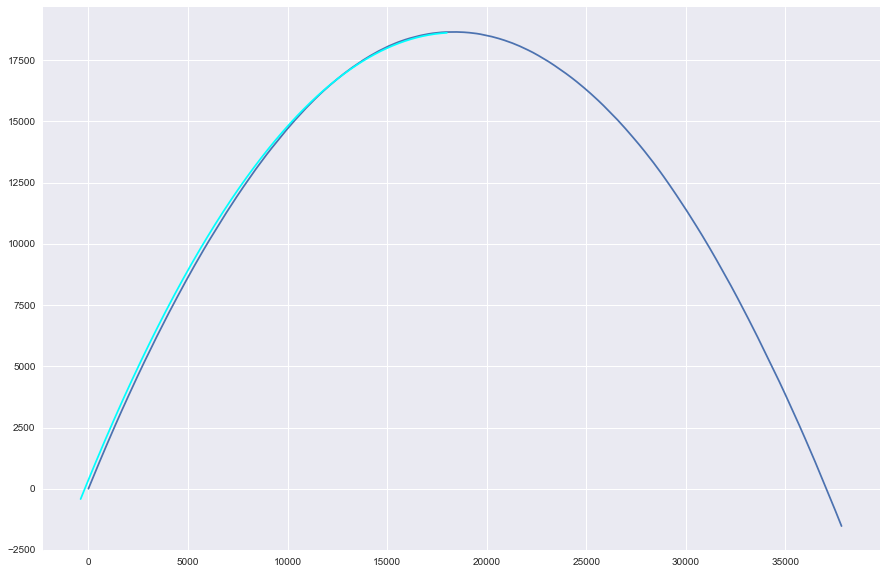

In [221]:
x = est[400]
past = kf.rewind(x, 610)
fig3, ax3 = plt.subplots(figsize=(15,10))
ax3.plot([x[0] for x in s], [x[1] for x in s])
ax3.plot(past[:,0], past[:,1], color='Cyan')

The first is better because we didn't predict as many states